# More Advanced Pipelines

Sometimes you will need more customized functionality in your pipeline.

## What we will accomplish

In this notebook we will:
- Return to our penguins data set example,
- See how to build custom transformer objects,
- Introduce `FunctionTransformer`,
- Again review the `fit`, `transform` and `fit_transform` paradigm and
- Build a pipeline to predict penguin type.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from seaborn import set_style, pairplot
set_style("whitegrid")

## Penguins Data

A motivating problem for this notebook will be our desire to build a model that classifies different penguins into three unique species. We saw a version of this `seaborn` data set in the `Imputation` notebook. 

Let's load the version we will use in this notebook.

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
penguins = pd.read_csv("../../Data/penguins_for_pipes.csv")

In [4]:
penguins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            333 non-null    object 
 1   island             333 non-null    object 
 2   bill_length_mm     333 non-null    float64
 3   bill_depth_mm      333 non-null    float64
 4   flipper_length_mm  333 non-null    float64
 5   body_mass_g        326 non-null    float64
 6   sex                330 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.3+ KB


In [5]:
peng_train, peng_test = train_test_split(penguins,
                                            random_state = 440,
                                            shuffle = True,
                                            test_size=.25)

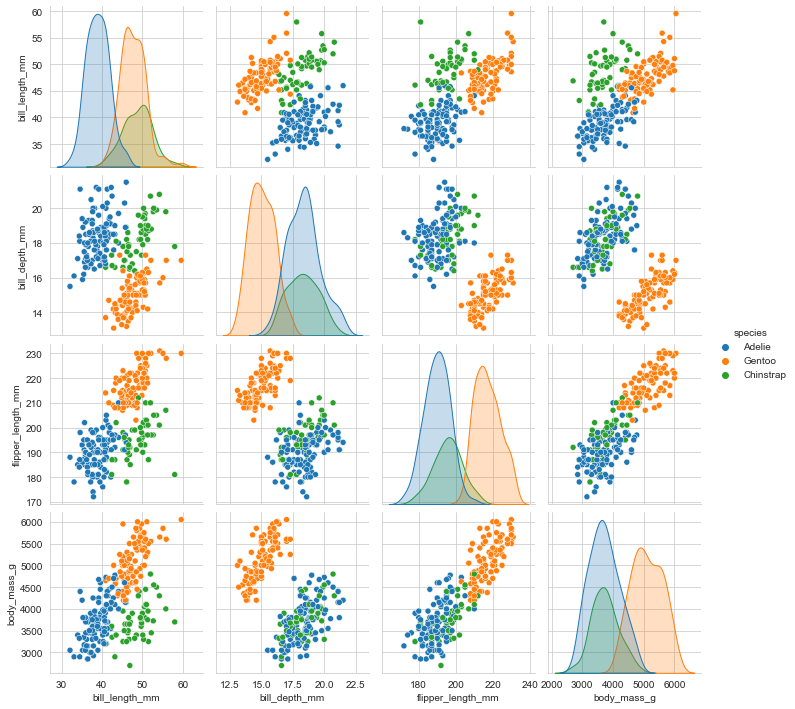

In [6]:
pairplot(peng_train, hue='species')

plt.show()

In [7]:
print(peng_train.island.value_counts())

print()

print(peng_train.sex.value_counts())

Biscoe       129
Dream         88
Torgersen     32
Name: island, dtype: int64

Male      129
Female    119
Name: sex, dtype: int64


## Our desired pipeline

Our desired pipeline for this model is:

1. Impute the missing values of `body_mass_g` with the `median` value,
2. Impute the missing values of `sex` with the most common value,
3. One hot encode `island` and `sex` and
4. Fit a random forest model to the data.

The reason that our basic pipeline approach may face issues here is that we are mixing data with categorical and numeric features. For example, just calling `SimpleImputer` in a pipeline will cause the same imputation to be applied to all missing values regardless of column. Another time this could be an issue is if you want to scale some columns but not others.

## Transformer objects

`sklearn` has the functionality for us to write our own custom <i>transformer objects</i> which we can use to make custom imputers. A transformer object in this context is an `sklearn` object that performs some transformation on the data. We have seen a number of these in prior notebooks including:
- `StandardScaler`,
- `PolynomialFeatures` and
- `SimpleImputer`.

### Making custom trasformer objects

We can now learn how to make our own transformer objects.

We will start by making a custom imputer for `body_mass_g`.

<i>Note that this material may be more easily digested if you have consumed the optional `Classes and Objects in Python` notebook in the `Python Prep` material in this repository.</i>

In [8]:
## We'll need these
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

In [9]:
## Define our custom imputer
class BodyMassImputer(BaseEstimator, TransformerMixin):
    # Class Constructor 
    # This allows you to initiate the class when you call
    # BodyMassImputer
    def __init__(self):
        # I want to initiate each object with
        # the SimpleImputer method
        self.SimpleImputer = SimpleImputer(strategy = "median")
    
    # For my fit method I'm just going to "steal"
    # SimpleImputer's fit method using only the
    # 'body_mass_g' column
    def fit(self, X, y = None ):
        self.SimpleImputer.fit(X['body_mass_g'].values.reshape(-1,1))
        return self
    
    # Now I want to transform the 'body_mass_g' columns
    # and return it with imputed values
    def transform(self, X, y = None):
        copy_X = X.copy()
        copy_X['body_mass_g'] = self.SimpleImputer.transform(copy_X['body_mass_g'].values.reshape(-1,1))
        return copy_X

We now have a custom imputer let's test it.

In [10]:
imputer = BodyMassImputer()

In [11]:
## Look at the data where body_mass_g is missing
peng_train.loc[peng_train.body_mass_g.isna()]

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
242,Gentoo,Biscoe,50.0,15.3,220.0,NaN,Male
29,Adelie,Dream,36.4,17.0,195.0,NaN,Female
271,Gentoo,Biscoe,43.2,14.5,208.0,NaN,Female
84,Adelie,Dream,35.7,18.0,202.0,NaN,Female


In [12]:
## Here is what results at the missing values of body_mass_g in the train set
## note we can use fit_transform because it is the training set
imputer.fit_transform(peng_train).loc[peng_train.body_mass_g.isna()]

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
242,Gentoo,Biscoe,50.0,15.3,220.0,4150.0,Male
29,Adelie,Dream,36.4,17.0,195.0,4150.0,Female
271,Gentoo,Biscoe,43.2,14.5,208.0,4150.0,Female
84,Adelie,Dream,35.7,18.0,202.0,4150.0,Female


We can make a custom imputer for `sex` in a similar fashion.

In [13]:
## Define our custom imputer
class SexImputer(BaseEstimator, TransformerMixin):
    # Class Constructor 
    # This allows you to initiate the class when you call
    # SexImputer
    def __init__(self):
        # I want to initiate each object with
        # the SimpleImputer method
        self.SimpleImputer = SimpleImputer(strategy='most_frequent')
    
    # For my fit method I'm just going to "steal"
    # SimpleImputer's fit method using only the
    # 'sex' column
    def fit(self, X, y=None):
        self.SimpleImputer.fit(X['sex'].values.reshape(-1,1))
        return self
    
    
    # Now I want to transform the 'sex' columns
    # and return it with imputed values
    def transform(self, X, y=None):
        copy_X = X.copy()
        copy_X['sex'] = self.SimpleImputer.transform(X['sex'].values.reshape(-1,1))
        return copy_X
    

In [14]:
imputer = SexImputer()

In [15]:
peng_train.loc[peng_train.sex.isna()]

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
32,Adelie,Dream,42.2,18.5,180.0,3550.0,NaN


In [16]:
imputer.fit_transform(peng_train).loc[peng_train.sex.isna()]

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
32,Adelie,Dream,42.2,18.5,180.0,3550.0,Male


Finally we need a one hot encoder for these data. Luckily we can use a `FunctionTransformer` object for this, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html">https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html</a>.

`FunctionTransformer` allows you to write a python function and have it applied to your data set as a transformer object.

In [17]:
from sklearn.preprocessing import FunctionTransformer

First we define a function that will take in the dataframe and return one with one hot encoded data for `island` and `sex`.

In [18]:
def one_hot_encoder(df):
    df_copy = df.copy()
    
    ## first replace Male Female with 0-1s
    df_copy['sex'] = pd.get_dummies(df['sex'])['Female'].copy()
    
    ## Now get island columns
    df_copy[['Biscoe', 'Dream', 'Torgersen']] = pd.get_dummies(df['island'])[['Biscoe', 'Dream', 'Torgersen']]
    
    return df_copy[['bill_length_mm', 'bill_depth_mm',
                       'flipper_length_mm', 'body_mass_g', 
                       'sex', 'Biscoe', 'Dream', 'Torgersen']]

In [19]:
peng_train.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
145,Adelie,Dream,41.5,18.5,201.0,4000.0,Male
101,Adelie,Biscoe,38.2,20.0,190.0,3900.0,Male
283,Gentoo,Biscoe,46.4,15.6,221.0,5000.0,Male
151,Chinstrap,Dream,45.2,17.8,198.0,3950.0,Female
224,Gentoo,Biscoe,40.9,13.7,214.0,4650.0,Female


In [20]:
## Look at the one hot encoded data
one_hot_encoder(peng_train).head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,Biscoe,Dream,Torgersen
145,41.5,18.5,201.0,4000.0,0,0,1,0
101,38.2,20.0,190.0,3900.0,0,1,0,0
283,46.4,15.6,221.0,5000.0,0,1,0,0
151,45.2,17.8,198.0,3950.0,1,0,1,0
224,40.9,13.7,214.0,4650.0,1,1,0,0


We can now wrap the function `one_hot_encoder` in the `FunctionTransformer` object to turn it into a transformer object that does the one hot encoding we would like.

In [22]:
one_hot_transformer = FunctionTransformer(one_hot_encoder)

In [23]:
one_hot_transformer

FunctionTransformer(func=<function one_hot_encoder at 0x17ef475e0>)

In [24]:
one_hot_transformer.transform(peng_train).head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,Biscoe,Dream,Torgersen
145,41.5,18.5,201.0,4000.0,0,0,1,0
101,38.2,20.0,190.0,3900.0,0,1,0,0
283,46.4,15.6,221.0,5000.0,0,1,0,0
151,45.2,17.8,198.0,3950.0,1,0,1,0
224,40.9,13.7,214.0,4650.0,1,1,0,0


Note that with `one_hot_transformer` we did not have to call `fit` prior to `transform` this is because `FunctionTransformer` does not need to be fitted, it is just applying the function we wrote.

### Making the pipeline

We can now put all of this together in a pipeline.

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [26]:
pipe = Pipeline([('body_mass_impute', BodyMassImputer()),
                    ('sex_impute', SexImputer()),
                    ('one_hot', FunctionTransformer(one_hot_encoder)),
                    ('rf', RandomForestClassifier(100, max_depth=5))])

In [27]:
pipe.fit(peng_train[['bill_length_mm', 'bill_depth_mm',
                       'flipper_length_mm', 'body_mass_g',
                       'island', 'sex']],
         peng_train['species'])

Pipeline(steps=[('body_mass_impute', BodyMassImputer()),
                ('sex_impute', SexImputer()),
                ('one_hot',
                 FunctionTransformer(func=<function one_hot_encoder at 0x17ef475e0>)),
                ('rf', RandomForestClassifier(max_depth=5))])

In [28]:
train_pred = pipe.predict(peng_train[['bill_length_mm', 'bill_depth_mm',
                       'flipper_length_mm', 'body_mass_g',
                       'island', 'sex']])

pipe.predict(peng_train[['bill_length_mm', 'bill_depth_mm',
                       'flipper_length_mm', 'body_mass_g',
                       'island', 'sex']])

array(['Adelie', 'Adelie', 'Gentoo', 'Chinstrap', 'Gentoo', 'Gentoo',
       'Adelie', 'Adelie', 'Adelie', 'Gentoo', 'Adelie', 'Adelie',
       'Chinstrap', 'Gentoo', 'Adelie', 'Gentoo', 'Adelie', 'Chinstrap',
       'Gentoo', 'Gentoo', 'Chinstrap', 'Gentoo', 'Gentoo', 'Gentoo',
       'Adelie', 'Adelie', 'Chinstrap', 'Gentoo', 'Chinstrap', 'Adelie',
       'Adelie', 'Adelie', 'Gentoo', 'Chinstrap', 'Adelie', 'Chinstrap',
       'Adelie', 'Gentoo', 'Adelie', 'Adelie', 'Chinstrap', 'Adelie',
       'Chinstrap', 'Gentoo', 'Adelie', 'Adelie', 'Gentoo', 'Gentoo',
       'Gentoo', 'Gentoo', 'Adelie', 'Chinstrap', 'Gentoo', 'Chinstrap',
       'Gentoo', 'Chinstrap', 'Chinstrap', 'Adelie', 'Chinstrap',
       'Gentoo', 'Adelie', 'Chinstrap', 'Adelie', 'Chinstrap', 'Gentoo',
       'Adelie', 'Gentoo', 'Chinstrap', 'Gentoo', 'Chinstrap', 'Gentoo',
       'Gentoo', 'Gentoo', 'Gentoo', 'Adelie', 'Adelie', 'Adelie',
       'Adelie', 'Chinstrap', 'Gentoo', 'Chinstrap', 'Chinstrap',
       'Adelie',

In [29]:
test_pred = pipe.predict(peng_test[['bill_length_mm', 'bill_depth_mm',
                       'flipper_length_mm', 'body_mass_g',
                       'island', 'sex']])

pipe.predict(peng_test[['bill_length_mm', 'bill_depth_mm',
                       'flipper_length_mm', 'body_mass_g',
                       'island', 'sex']])

array(['Adelie', 'Chinstrap', 'Adelie', 'Chinstrap', 'Adelie', 'Adelie',
       'Adelie', 'Gentoo', 'Chinstrap', 'Adelie', 'Gentoo', 'Adelie',
       'Adelie', 'Gentoo', 'Gentoo', 'Adelie', 'Adelie', 'Adelie',
       'Adelie', 'Gentoo', 'Chinstrap', 'Gentoo', 'Adelie', 'Adelie',
       'Chinstrap', 'Gentoo', 'Adelie', 'Adelie', 'Gentoo', 'Adelie',
       'Chinstrap', 'Adelie', 'Adelie', 'Adelie', 'Adelie', 'Chinstrap',
       'Adelie', 'Adelie', 'Adelie', 'Chinstrap', 'Gentoo', 'Gentoo',
       'Chinstrap', 'Adelie', 'Gentoo', 'Adelie', 'Adelie', 'Gentoo',
       'Gentoo', 'Adelie', 'Chinstrap', 'Gentoo', 'Chinstrap', 'Adelie',
       'Gentoo', 'Adelie', 'Adelie', 'Adelie', 'Gentoo', 'Adelie',
       'Adelie', 'Adelie', 'Adelie', 'Adelie', 'Gentoo', 'Chinstrap',
       'Chinstrap', 'Gentoo', 'Gentoo', 'Chinstrap', 'Chinstrap',
       'Chinstrap', 'Chinstrap', 'Adelie', 'Adelie', 'Gentoo', 'Adelie',
       'Adelie', 'Chinstrap', 'Gentoo', 'Gentoo', 'Gentoo', 'Adelie',
       'Chinstrap'

In [30]:
from sklearn.metrics import accuracy_score

In [32]:
print("Training accuracy", accuracy_score(peng_train.species, train_pred))
print("Test accuracy", accuracy_score(peng_test.species, test_pred))

Training accuracy 0.9959839357429718
Test accuracy 1.0


You should now be able to create more complicated pipelines!

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2022.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)